In [1]:
! git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 21481 (delta 38), reused 20 (delta 10), pack-reused 21400
Receiving objects: 100% (21481/21481), 16.91 MiB | 30.02 MiB/s, done.
Resolving deltas: 100% (15707/15707), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728    

In [2]:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from imblearn import pipeline as impipeline
from sklearn import pipeline as skpipeline
from sklearn import impute
from sklearn import metrics

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/contest/data_text/train.csv', index_col=0)
data

,title,text,images,source
Id,,,,
1,Міністри Зеленського лишають мільйони пацієнті...,Понад півтора мільйони пацієнтів із тяжкими ді...,NaN,5
2,В АМКУ звертаються щодо незаконної державної д...,За 15 років державна підтримка виробництва ене...,fd92a3dd-1109-49d8-8f5f-eeed72da22ef.png,6
5,У Польщі виявили майже 16 тисяч нових хворих н...,У Польщі виявили 15 698 нових хворих на корона...,f4a284d0-9bb7-4910-8a62-a7bfd0ec29b6.png,2
9,Закриття міжбанку: гривня трохи ослабла,2 жовтня котирування гривні до долара на закри...,NaN,3
10,"У Москві помер український шахіст із бази ""Мир...",У п'ятницю низка російських ЗМІ повідомили про...,"2cbb2339-6dd2-4000-a53c-225ec7aad892.png,d5233...",0
...,...,...,...,...
32366,"""Укрзалізниця"" просить Раду у бюджеті-2021 зак...","""Укрзалізниця"" закликає парламент закласти у д...",NaN,3
32367,Сніг та 20-градусні морози протримаються до ви...,"У вівторок, 16 лютого, в Україні буде без істо...",NaN,2
32368,"Україна хоче оподаткувати Google, Facebook та ...","Гетманцев розповів, як Україна оподатковуватим...",NaN,6


In [6]:
train_text_features = pd.read_csv('/content/drive/MyDrive/contest/features/train-text-features.csv', index_col=0)
train_text_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.495396,1.658479,-0.001814,0.511697,-0.344006,-0.437909,0.401632,0.342265,0.043387,1.404830,-0.482979,-0.513041,1.315945,0.720766,0.220555,-0.742780,-0.197139,0.223958,0.446340,0.727496,-1.475043,-0.362063,-0.044476,0.950108,-0.462881,1.015473,-0.101479,2.488953,-0.431753,0.115471,1.606948,1.958550,1.540230,1.248913,-0.167601,0.426451,0.338525,1.367081,-0.552212,-0.034261,...,-0.326085,-0.998408,0.092934,1.367658,-0.287793,1.179220,0.363347,0.239282,-1.384208,-0.494225,-0.250143,0.651387,-0.783828,0.739106,-1.305669,0.100876,-0.047367,-0.446772,0.608520,0.277495,-2.231946,-0.510547,-0.818816,-0.260585,-0.621246,-0.713614,0.106401,0.294114,0.458935,-0.738112,-1.706150,0.830737,-0.940207,0.313868,0.169310,-0.677958,0.714097,-0.540704,0.188809,1.014629
2,-1.264550,-0.361843,0.208906,-0.373935,1.082783,-0.608718,-0.254210,-0.243627,0.425724,-1.515065,0.800010,1.255799,0.400313,-0.354587,0.794049,0.455952,-0.715318,1.337099,0.047033,-0.514894,-0.197234,-0.112508,0.281335,-1.751299,-0.707432,0.661830,-0.354732,-0.403837,0.517885,-0.890461,-0.782873,-0.067178,0.935501,-1.314813,1.024229,1.330360,1.133010,-0.862730,0.188835,0.904188,...,-0.174282,-1.836568,0.430642,0.965243,0.257524,1.272612,-1.869631,0.149236,1.330269,-1.397187,0.427582,-0.986605,1.854229,0.394057,1.172300,0.270704,0.268355,0.514062,-0.209562,-1.051691,0.845164,-0.314335,0.475959,-0.939663,-0.761981,1.919520,1.336151,1.899170,-0.953898,-0.256924,-0.182247,0.967782,-0.941131,-0.195775,-0.710576,1.210445,-0.619651,-0.276618,-0.020087,-0.457537
5,-35.783810,-36.757961,-35.672127,-36.941479,-35.312115,-36.542427,-35.404308,-35.935234,-36.915722,-37.054871,-36.309284,-37.243401,-37.132629,-36.032661,-37.321220,-35.898174,-36.979191,-37.550125,-36.026257,-36.617317,-36.318222,-35.362572,-36.718513,-36.850716,-35.505257,-36.109962,-36.565353,-36.640411,-36.682549,-36.149487,-36.350624,-35.750931,-36.705650,-35.869225,-36.361343,-35.547882,-37.122116,-37.637161,-36.427574,-36.781677,...,-36.195763,-37.490005,-35.768913,-36.309586,-36.739761,-35.164635,-35.657143,-38.098068,-36.739513,-36.108788,-36.928040,-36.594513,-37.087250,-36.269897,-37.782341,-35.383633,-36.546307,-35.613914,-37.385891,-36.491669,-36.698463,-37.318230,-35.775845,-35.231686,-36.262344,-37.770382,-36.412441,-35.867439,-37.422112,-36.129936,-36.392021,-35.428406,-36.272060,-36.591171,-36.233910,-36.521759,-36.296181,-36.869747,-36.815685,-36.972244
9,-47.477837,-48.064194,-48.308899,-46.768993,-48.103470,-47.563118,-47.304844,-47.548874,-46.860527,-47.952072,-47.355988,-47.810898,-47.836006,-47.572189,-47.605167,-47.847374,-48.687317,-48.157654,-48.299229,-48.332176,-47.654427,-48.431686,-46.755039,-47.782745,-47.551079,-48.187084,-47.625343,-46.788143,-48.189198,-47.822525,-47.752853,-47.954132,-46.534218,-47.232018,-47.852386,-48.480339,-48.458206,-47.977051,-47.784954,-48.209923,...,-46.601501,-47.405716,-47.416233,-47.621677,-47.409782,-48.039722,-47.803616,-47.483269,-47.554642,-47.717491,-47.425526,-47.977009,-46.890881,-47.191090,-47.434097,-47.470573,-48.229614,-48.443954,-47.561230,-47.149860,-47.824188,-47.472881,-47.560795,-47.432827,-48.068676,-47.162163,-47.960526,-47.741947,-48.381321,-47.557175,-47.856594,-47.560307,-47.172672,-48.066071,-47.085686,-46.218834,-48.255634,-48.062859,-46.865044,-47.521065
10,0.392212,-0.756164,-1.383295,1.683602,0.536265,-0.166082,0.380611,-0.122716,-0.263201,-0.117077,-0.534360,1.592536,-0.510844,0.706194,-0.061569,0.545693,0.142497,-0.720901,-1.173313,-0.561923,0.598149,1.361036,0.567323,-1.541084,0.637018,0.169915,0.600835,-2.081728,0.771322,-0.355877,0.588991,-0.195899,-1.716

In [7]:
train_images_features = pd.read_csv('/content/drive/MyDrive/contest/features/train-images-features.csv', index_col=0)
train_images_features = train_images_features.drop(columns=['1280'], axis=1)
train_images_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.335204,3.282005,3.151573,0.219543,0.212870,4.238270,0.198296,0.270647,3.653566,3.976311,0.264508,3.530931,0.259503,3.829927,0.559008,0.170510,0.238472,0.117984,0.203391,3.692210,0.181216,0.138967,3.827159,3.636702,3.657410,0.231920,0.105495,0.148129,3.360028,3.892643,0.222755,0.169740,3.729895,0.193299,0.183093,3.974160,0.221973,0.316800,0.163743,0.222098,...,3.684582,3.823920,3.719368,0.132070,0.179960,3.511130,0.145640,0.145508,3.527317,0.193818,0.120470,3.902761,3.532239,3.636030,0.233492,3.538194,3.665078,0.135276,0.144709,0.153997,3.680769,0.184967,0.255932,3.701681,0.176124,0.265084,0.229765,3.659227,0.145419,0.130171,3.631585,0.166194,3.603875,3.555405,3.742685,0.157729,3.475101,0.215752,3.718582,3.739745
5,0.335181,3.282325,3.151866,0.219676,0.212764,4.238363,0.198371,0.270624,3.653924,3.976705,0.264554,3.531240,0.259600,3.830174,0.559066,0.170523,0.238507,0.117988,0.203502,3.692590,0.181106,0.139049,3.827785,3.637128,3.657548,0.231944,0.105469,0.148235,3.360461,3.892820,0.222735,0.169680,3.730308,0.193389,0.183135,3.974877,0.222039,0.316747,0.163756,0.222029,...,3.685146,3.824314,3.719751,0.132114,0.179951,3.511538,0.145700,0.145545,3.527578,0.193761,0.120423,3.903151,3.532457,3.636415,0.233563,3.538871,3.665158,0.135222,0.144700,0.154058,3.681173,0.185089,0.255872,3.701994,0.176185,0.265116,0.229815,3.659576,0.145512,0.130125,3.631716,0.166259,3.604184,3.555690,3.742982,0.157671,3.475488,0.215712,3.718818,3.739997
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.337960,3.307029,3.175484,0.221355,0.214483,4.270462,0.199934,0.272739,3.681363,4.006116,0.266532,3.557806,0.261440,3.859113,0.563439,0.171945,0.240297,0.118818,0.205132,3.720243,0.182066,0.140010,3.856199,3.664602,3.684815,0.233763,0.106268,0.149274,3.385632,3.921842,0.224224,0.170970,3.758356,0.195060,0.184502,4.004783,0.223605,0.319678,0.164789,0.223770,...,3.713170,3.853107,3.748163,0.133074,0.181442,3.538046,0.146780,0.146625,3.554585,0.195239,0.121173,3.932564,3.559103,3.663708,0.235390,3.565445,3.692661,0.136046,0.145785,0.155428,3.708570,0.186653,0.257792,3.729787,0.177458,0.267210,0.231630,3.687072,0.146549,0.131173,3.659128,0.167393,3.631295,3.582447,3.771239,0.158927,3.501930,0.217259,3.746905,3.768065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [8]:
test_text_features = pd.read_csv('/content/drive/MyDrive/contest/features/test-text-features.csv', index_col=0)
test_text_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-27.444374,-27.914072,-28.369684,-26.606539,-28.320129,-27.389799,-27.326281,-27.446133,-26.395342,-27.802853,-27.407429,-27.555710,-27.100674,-27.467209,-27.372078,-28.173014,-28.781755,-28.292770,-28.150208,-28.628288,-27.848717,-28.643600,-26.388168,-27.650314,-28.041374,-27.810213,-27.493023,-26.177923,-28.203091,-27.755037,-27.240292,-28.233906,-25.961905,-26.807758,-27.795094,-28.476410,-28.310827,-27.767410,-27.808210,-28.290129,...,-26.091513,-27.038670,-26.835461,-27.705452,-27.217579,-28.045223,-28.095684,-27.163059,-27.206755,-27.687218,-26.962927,-28.009657,-26.183441,-26.862350,-27.154606,-27.097773,-28.266644,-28.674812,-27.249149,-27.077351,-27.920006,-27.456745,-27.015690,-27.682045,-28.398291,-26.599072,-28.122131,-26.858070,-28.495291,-27.593859,-27.747900,-26.976837,-26.886242,-28.195374,-26.652618,-25.615486,-28.362726,-28.353111,-26.513474,-27.117491
3,-81.462280,-81.381271,-81.155121,-81.192375,-80.940567,-81.480576,-81.229340,-81.242325,-81.089935,-81.551964,-81.028519,-80.936180,-81.138084,-81.250977,-81.089859,-81.146843,-81.280716,-81.014862,-81.396309,-81.312943,-81.245255,-81.361725,-81.100021,-81.610260,-81.307411,-81.000908,-81.424072,-81.319977,-81.026405,-81.482285,-81.231064,-81.240913,-81.154762,-81.394318,-81.090248,-80.842484,-80.873795,-81.449509,-81.235397,-81.046814,...,-81.205765,-81.543053,-81.525703,-81.125015,-81.106857,-80.868896,-81.647018,-81.252701,-80.935715,-81.525703,-81.239471,-81.477722,-80.981140,-81.081238,-81.028946,-81.196335,-81.223450,-81.147705,-81.380867,-81.456604,-81.102463,-81.225983,-81.276749,-81.255356,-81.327171,-81.128082,-81.077171,-81.042686,-81.489487,-81.277649,-81.266693,-81.074570,-81.397629,-81.349960,-81.620697,-81.122757,-81.321640,-81.274567,-81.227287,-81.393784
4,-1.678005,1.733181,-0.197218,0.426128,-0.476843,-0.329220,0.115848,0.283908,0.000284,1.490310,-0.338646,-0.275672,1.275172,0.627779,0.451248,-0.622007,-0.154294,0.323494,0.516315,0.874383,-1.482937,-0.267315,0.024959,0.848663,-0.500379,1.172392,-0.094387,2.490448,-0.463333,0.074625,1.694811,1.797073,1.590966,1.129190,-0.023424,0.668372,0.541341,1.419779,-0.581708,-0.257476,...,-0.610947,-1.106515,0.080360,1.423265,-0.387096,1.159468,0.408388,0.200457,-1.325033,-0.108716,-0.338235,0.861102,-0.625370,0.689512,-1.427462,0.203292,-0.036736,-0.398037,0.653177,0.434808,-2.208106,-0.726208,-0.773442,-0.262391,-0.427261,-0.823143,0.224172,0.327694,0.381383,-0.687765,-1.725981,0.934262,-0.968853,0.383061,-0.002432,-0.841047,0.911955,-0.641625,0.332510,1.247679
6,-49.148617,-50.262138,-50.453827,-48.911186,-49.806290,-49.537109,-49.457687,-49.364677,-49.077385,-49.593952,-49.346592,-49.623749,-49.947319,-49.723618,-49.636322,-49.805901,-50.313663,-49.617085,-49.945007,-50.209175,-49.287628,-50.258797,-48.850937,-49.638058,-49.039742,-50.194286,-49.924500,-48.916126,-50.053719,-49.763176,-49.850479,-50.449181,-48.904427,-49.758682,-50.184071,-50.536495,-50.232380,-49.453365,-49.876083,-49.937355,...,-48.675621,-48.946045,-49.453915,-49.404343,-49.243019,-50.133743,-49.341087,-49.530983,-49.547817,-49.447678,-49.262135,-49.906044,-48.905991,-49.494457,-49.138496,-49.130096,-50.207729,-50.109756,-49.132217,-49.394314,-49.663242,-49.351566,-49.863911,-49.598171,-49.870174,-48.629093,-49.875225,-49.955048,-50.005516,-49.729362,-49.784966,-49.781837,-48.855705,-50.084908,-48.577305,-48.584682,-50.093529,-50.001892,-49.018208,-49.295544
7,-45.637901,-45.141541,-45.375927,-46.338287,-45.482002,-46.277264,-45.421501,-45.540096,-46.001038,-46.432961,-46.337776,-46.595497,-44.933716,-45.792496,-44.924168,-45.817234,-45.115822,-46.3

In [9]:
test_images_features = pd.read_csv('/content/drive/MyDrive/contest/features/test-images-features.csv', index_col=0)
test_images_features = test_images_features.drop(columns=['1280'], axis=1)
test_images_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.337752,3.308189,3.176431,0.221426,0.214422,4.271514,0.199871,0.272776,3.682470,4.007264,0.266575,3.558933,0.261378,3.860225,0.563538,0.171988,0.240295,0.118701,0.205061,3.721548,0.182082,0.140051,3.857542,3.665862,3.686054,0.233614,0.106265,0.149288,3.386781,3.923084,0.224302,0.171012,3.759447,0.195014,0.184472,4.006030,0.223520,0.319425,0.164732,0.223820,...,3.714342,3.854368,3.749432,0.133055,0.181527,3.539216,0.146734,0.146643,3.555806,0.195208,0.121186,3.933967,3.560230,3.664870,0.235382,3.566514,3.693932,0.136071,0.145884,0.155477,3.709955,0.186683,0.257726,3.730931,0.177482,0.267231,0.231510,3.688266,0.146557,0.131137,3.660349,0.167405,3.632492,3.583609,3.772483,0.158886,3.503058,0.217410,3.747943,3.769296
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32363,0.336715,3.294582,3.163644,0.220445,0.213626,4.254751,0.199130,0.271651,3.667601,3.991529,0.265543,3.544564,0.260412,3.844690,0.561229,0.171176,0.239380,0.118315,0.204317,3.706433,0.181605,0.139505,3.842127,3.650988,3.671490,0.232739,0.105838,0.148749,3.373069,3.907426,0.223422,0.170415,3.744426,0.194289,0.183770,3.989824,0.222726,0.318298,0.164212,0.222869,...,3.699015,3.838758,3.734071,0.132568,0.180741,3.524750,0.146166,0.146033,3.540918,0.194534,0.120807,3.918011,3.545835,3.649995,0.234406,3.552015,3.679274,0.135605,0.145276,0.154748,3.694996,0.185783,0.256882,3.715846,0.176798,0.266168,0.230678,3.673376,0.145922,0.130668,3.645725,0.166777,3.617854,3.569136,3.757205,0.158285,3.488567,0.216481,3.733076,3.754140
32364,0.337242,3.301994,3.170802,0.220916,0.214094,4.264655,0.199379,0.272270,3.675840,4.000738,0.266168,3.552562,0.261175,3.853315,0.562107,0.171536,0.239900,0.118555,0.204691,3.7149

In [23]:
train_data = pd.concat([train_text_features, train_images_features], axis=1)
train_data.columns = list(range(len(train_data.columns)))
train_data = pd.concat([train_data, data['source']], axis=1)
train_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303,source
1,-1.495396,1.658479,-0.001814,0.511697,-0.344006,-0.437909,0.401632,0.342265,0.043387,1.404830,-0.482979,-0.513041,1.315945,0.720766,0.220555,-0.742780,-0.197139,0.223958,0.446340,0.727496,-1.475043,-0.362063,-0.044476,0.950108,-0.462881,1.015473,-0.101479,2.488953,-0.431753,0.115471,1.606948,1.958550,1.540230,1.248913,-0.167601,0.426451,0.338525,1.367081,-0.552212,-0.034261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2,-1.264550,-0.361843,0.208906,-0.373935,1.082783,-0.608718,-0.254210,-0.243627,0.425724,-1.515065,0.800010,1.255799,0.400313,-0.354587,0.794049,0.455952,-0.715318,1.337099,0.047033,-0.514894,-0.197234,-0.112508,0.281335,-1.751299,-0.707432,0.661830,-0.354732,-0.403837,0.517885,-0.890461,-0.782873,-0.067178,0.935501,-1.314813,1.024229,1.330360,1.133010,-0.862730,0.188835,0.904188,...,3.823920,3.719368,0.132070,0.179960,3.511130,0.145640,0.145508,3.527317,0.193818,0.120470,3.902761,3.532239,3.636030,0.233492,3.538194,3.665078,0.135276,0.144709,0.153997,3.680769,0.184967,0.255932,3.701681,0.176124,0.265084,0.229765,3.659227,0.145419,0.130171,3.631585,0.166194,3.603875,3.555405,3.742685,0.157729,3.475101,0.215752,3.718582,3.739745,6
5,-35.783810,-36.757961,-35.672127,-36.941479,-35.312115,-36.542427,-35.404308,-35.935234,-36.915722,-37.054871,-36.309284,-37.243401,-37.132629,-36.032661,-37.321220,-35.898174,-36.979191,-37.550125,-36.026257,-36.617317,-36.318222,-35.362572,-36.718513,-36.850716,-35.505257,-36.109962,-36.565353,-36.640411,-36.682549,-36.149487,-36.350624,-35.750931,-36.705650,-35.869225,-36.361343,-35.547882,-37.122116,-37.637161,-36.427574,-36.781677,...,3.824314,3.719751,0.132114,0.179951,3.511538,0.145700,0.145545,3.527578,0.193761,0.120423,3.903151,3.532457,3.636415,0.233563,3.538871,3.665158,0.135222,0.144700,0.154058,3.681173,0.185089,0.255872,3.701994,0.176185,0.265116,0.229815,3.659576,0.145512,0.130125,3.631716,0.166259,3.604184,3.555690,3.742982,0.157671,3.475488,0.215712,3.718818,3.739997,2
9,-47.477837,-48.064194,-48.308899,-46.768993,-48.103470,-47.563118,-47.304844,-47.548874,-46.860527,-47.952072,-47.355988,-47.810898,-47.836006,-47.572189,-47.605167,-47.847374,-48.687317,-48.157654,-48.299229,-48.332176,-47.654427,-48.431686,-46.755039,-47.782745,-47.551079,-48.187084,-47.625343,-46.788143,-48.189198,-47.822525,-47.752853,-47.954132,-46.534218,-47.232018,-47.852386,-48.480339,-48.458206,-47.977051,-47.784954,-48.209923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
10,0.392212,-0.756164,-1.383295,1.683602,0.536265,-0.166082,0.380611,-0.122716,-0.263201,-0.117077,-0.534360,1.592536,-0.510844,0.706194,-0.061569,0.545693,0.142497,-0.720901,-1.173313,-0.561923,0.598149,1.361036,0.567323,-1.541084,0.637018,0.169915,0.600835,-2.081728,0.771322,-0.355877,0.588991,-0.195899,-1.716144,-0.484603,-0.810106,1.501026,1.007010,1.290713,-1.633265,-0.173779,...,3.853107,3.748163,0.133074,0.181442,3.538046,0.146780,0.146625,3.554585,0.195239,0.121173,3.932564,3.559103,3.663708,0.235390,3.565445,3.692661,0.136046,0.145785,0.155428,3.708570,0.186653,0.257792,3.729787,0.177458,0.267210,0.231630,3.687072,0.146549,0.131173,3.659128,0.167393,3.631295,3.582447,3.771239,0.158927,3.501930,0.217259,3.746905,3.768065,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [25]:
test_data = pd.concat([test_text_features, test_images_features], axis=1)
test_data.columns = list(range(len(test_data.columns)))
test_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,-27.444374,-27.914072,-28.369684,-26.606539,-28.320129,-27.389799,-27.326281,-27.446133,-26.395342,-27.802853,-27.407429,-27.555710,-27.100674,-27.467209,-27.372078,-28.173014,-28.781755,-28.292770,-28.150208,-28.628288,-27.848717,-28.643600,-26.388168,-27.650314,-28.041374,-27.810213,-27.493023,-26.177923,-28.203091,-27.755037,-27.240292,-28.233906,-25.961905,-26.807758,-27.795094,-28.476410,-28.310827,-27.767410,-27.808210,-28.290129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-81.462280,-81.381271,-81.155121,-81.192375,-80.940567,-81.480576,-81.229340,-81.242325,-81.089935,-81.551964,-81.028519,-80.936180,-81.138084,-81.250977,-81.089859,-81.146843,-81.280716,-81.014862,-81.396309,-81.312943,-81.245255,-81.361725,-81.100021,-81.610260,-81.307411,-81.000908,-81.424072,-81.319977,-81.026405,-81.482285,-81.231064,-81.240913,-81.154762,-81.394318,-81.090248,-80.842484,-80.873795,-81.449509,-81.235397,-81.046814,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.678005,1.733181,-0.197218,0.426128,-0.476843,-0.329220,0.115848,0.283908,0.000284,1.490310,-0.338646,-0.275672,1.275172,0.627779,0.451248,-0.622007,-0.154294,0.323494,0.516315,0.874383,-1.482937,-0.267315,0.024959,0.848663,-0.500379,1.172392,-0.094387,2.490448,-0.463333,0.074625,1.694811,1.797073,1.590966,1.129190,-0.023424,0.668372,0.541341,1.419779,-0.581708,-0.257476,...,3.714342,3.854368,3.749432,0.133055,0.181527,3.539216,0.146734,0.146643,3.555806,0.195208,0.121186,3.933967,3.560230,3.664870,0.235382,3.566514,3.693932,0.136071,0.145884,0.155477,3.709955,0.186683,0.257726,3.730931,0.177482,0.267231,0.231510,3.688266,0.146557,0.131137,3.660349,0.167405,3.632492,3.583609,3.772483,0.158886,3.503058,0.217410,3.747943,3.769296
6,-49.148617,-50.262138,-50.453827,-48.911186,-49.806290,-49.537109,-49.457687,-49.364677,-49.077385,-49.593952,-49.346592,-49.623749,-49.947319,-49.723618,-49.636322,-49.805901,-50.313663,-49.617085,-49.945007,-50.209175,-49.287628,-50.258797,-48.850937,-49.638058,-49.039742,-50.194286,-49.924500,-48.916126,-50.053719,-49.763176,-49.850479,-50.449181,-48.904427,-49.758682,-50.184071,-50.536495,-50.232380,-49.453365,-49.876083,-49.937355,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-45.637901,-45.141541,-45.375927,-46.338287,-45.482002,-46.277264,-45.421501,-45.540096,-46.001038,-46.432961,-46.337776,-46.595497,-44.933716,-45.792496,-44.924168,-45.817234,-45.115822,-46.310616,-45.228104,-45.649799,-46.510300,-45.500206,-45.981358,-45.456024,-46.673809,-45.371296,-45.560974,-45.507576,-46.194630,-44.797691,-45.256363,-45.506939,-46.559486,-44.994022,-45.564434,-45.580925,-45.407410,-45.951180,-45.634415,-46.028057,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32362,-44.108364,-44.048580,-43.451447,-44.748863,-44.288460,-43.640266,-44.661922,-43.729034,-44.361820,-44.025780,-43.932076,-44.111816,-44.236771,-44.961845,-44.802368,-44.065384,-44.12604

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


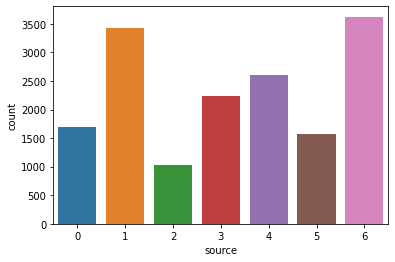

In [12]:
sns.countplot(train_data['source'])

In [109]:
lgbm = lgb.LGBMClassifier
best_lgbm = {
    # 'device_type':'gpu',
    # 'subsample_for_bin': 80000, 
    # 'subsample': 0.8888888888888888, 
    # 'reg_lambda': 0.4897959183673469, 
    # 'reg_alpha': 0.7346938775510203, 
    # 'num_leaves': 110, 
    # 'min_child_samples': 20, 
    # 'learning_rate': 0.14204418450916512, 
    # 'is_unbalance': True, 
    # 'colsample_bytree': 0.6444444444444444, 
    # 'boosting_type': 'gbdt',
    # 'verbose': 2,
    # 'verbosity': 3,
    # 'verbose_eval': True,
    'booster': 'gbdt',
    'colsample_bytree': 0.4,
    'device_type': 'gpu',
    'learning_rate': 0.18000000000000002,
    'max_bin': 150,
    'max_depth': -1,
    'metrics': 'multiclass',
    'min_child_samples': 100,
    'min_child_weight': 1,
    'min_split_gain': 0.4,
    'n_estimators': 400,
    'num_leaves': 30,
    'reg_alpha': 0.1,
    'reg_lambda': 0,
    'scale_pos_weight': 25,
    'subsample': 0.30000000000000004
}

In [110]:
pipe_lgbm = impipeline.make_pipeline(
    # impute.SimpleImputer(strategy='mean'),
    # RandomOverSampler(),
    # StandardScaler(), 
    lgbm(**best_lgbm),
    # verbose=True
)

In [111]:
X, y = train_data.drop(columns=['source']), train_data['source']

In [112]:
pipe_lgbm.fit(X, y)

Pipeline(memory=None,
         steps=[('lgbmclassifier',
                 LGBMClassifier(booster='gbdt', boosting_type='gbdt',
                                class_weight=None, colsample_bytree=0.4,
                                device_type='gpu', importance_type='split',
                                learning_rate=0.18000000000000002, max_bin=150,
                                max_depth=-1, metrics='multiclass',
                                min_child_samples=100, min_child_weight=1,
                                min_split_gain=0.4, n_estimators=400, n_jobs=-1,
                                num_leaves=30, objective=None,
                                random_state=None, reg_alpha=0.1, reg_lambda=0,
                                scale_pos_weight=25, silent=True,
                                subsample=0.30000000000000004,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

In [113]:
# gbm.save_model('mode.pkl')

In [114]:
y_pred = pipe_lgbm.predict(X)
metrics.f1_score(y, y_pred, average='macro')

0.9886812815998546

In [115]:
y_pred = pipe_lgbm.predict(test_data)

In [116]:
y_pred

array([3, 6, 5, ..., 0, 4, 0])

In [117]:
preds_old = pd.read_csv('/content/submission-xlm-roberta-large-v1.csv', index_col=0)
preds_old

,Predicted
Id,
0,3
3,6
4,5
6,3
7,4
...,...
32362,1
32363,5
32364,0


In [118]:
metrics.f1_score(preds_old['Predicted'], y_pred, average='macro')

0.9510864847018256

In [119]:
df_res = pd.DataFrame(y_pred, index=test_data.index)
df_res.columns = ['Predicted']
df_res.index = df_res.index.rename('Id')
df_res

,Predicted
Id,
0,3
3,6
4,5
6,3
7,4
...,...
32362,1
32363,5
32364,0


In [61]:
df_res.to_csv('./lgb-efficient_net-xlm-roberta-large-scaler.csv')

In [104]:
params = {
    'booster': ['dart', 'gbdt'],
    'n_estimators': [400, 700],
    'max_depth': [-1,15,20,25],
    'num_leaves': [50, 100, 200],
    'min_split_gain': [0.3, 0.4],
    'num_leaves': np.arange(5, 50, 5), 
    'min_child_samples': np.arange(100, 500, 100), 
    'min_child_weight': [1e-5, 1e-2, 1e-1, 1, 1e2, 1e4],
    'subsample': np.arange(0.1, 1, 0.1), 
    'colsample_bytree': np.arange(0.1, 1, 0.1),
    'reg_alpha': [0, 1e-1, 1, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 10, 50, 100],
    'scale_pos_weight': [25, 75, 100, 1000],
    'max_bin': [100, 150, 255, 500],
    'learning_rate': np.arange(0.01, 0.2, 0.01),
    'device_type': ['gpu'],
    'metrics': ['cross_entropy', 'multiclass', 'f1_macro'],
}

In [105]:
# create the Kfold object
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, random_state=42)
# create the grid search object
n_iter=100
grid = RandomizedSearchCV(
    estimator=lgbm(), 
    param_distributions=params,
    cv=kfold,
    n_jobs=-1,
    n_iter=n_iter,
    refit="f1_macro",
)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [106]:
# fit grid search
%time best_model = grid.fit(X, y)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[LightGBM] [Warning] Unknown parameter: booster
CPU times: user 1min 29s, sys: 8.98 s, total: 1min 38s
Wall time: 1h 22min 53s


In [107]:
best_model.best_params_

{'booster': 'gbdt',
 'colsample_bytree': 0.4,
 'device_type': 'gpu',
 'learning_rate': 0.18000000000000002,
 'max_bin': 150,
 'max_depth': -1,
 'metrics': 'multiclass',
 'min_child_samples': 100,
 'min_child_weight': 1,
 'min_split_gain': 0.4,
 'n_estimators': 400,
 'num_leaves': 30,
 'reg_alpha': 0.1,
 'reg_lambda': 0,
 'scale_pos_weight': 25,
 'subsample': 0.30000000000000004}

In [108]:
best_model.best_score_

0.9621685520124259